<a href="https://colab.research.google.com/github/Ahmed-M-Elshazly/Homework-6/blob/main/Homework_6_Problem_1_a_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Homework 6
#Problem 2-b
#Ahmed Elshazly
#801420724

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
import time
from datetime import timedelta
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

In [ ]:
file_path = url = 'https://raw.githubusercontent.com/Ahmed-M-Elshazly/Database/main/Housing.csv'
housing = pd.DataFrame(pd.read_csv(file_path))
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
drop_first_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
no_drop_first_columns = ['furnishingstatus']


encoder_drop_first = OneHotEncoder(drop='first', sparse_output=False)
encoder_no_drop_first = OneHotEncoder(drop=None, sparse_output=False)


encoded_drop_first = encoder_drop_first.fit_transform(housing[drop_first_columns])
encoded_drop_first_df = pd.DataFrame(encoded_drop_first, columns=encoder_drop_first.get_feature_names_out(drop_first_columns))


encoded_no_drop_first = encoder_no_drop_first.fit_transform(housing[no_drop_first_columns])
encoded_no_drop_first_df = pd.DataFrame(encoded_no_drop_first, columns=encoder_no_drop_first.get_feature_names_out(no_drop_first_columns))


housing_encoded = housing.drop(columns=drop_first_columns + no_drop_first_columns)


df_pandas_encoded = pd.concat([housing_encoded, encoded_drop_first_df, encoded_no_drop_first_df], axis=1)


print(df_pandas_encoded.head())

      price  area  bedrooms  bathrooms  stories  parking  mainroad_yes  \
0  13300000  7420         4          2        3        2           1.0   
1  12250000  8960         4          4        4        3           1.0   
2  12250000  9960         3          2        2        2           1.0   
3  12215000  7500         4          2        2        3           1.0   
4  11410000  7420         4          1        2        2           1.0   

   guestroom_yes  basement_yes  hotwaterheating_yes  airconditioning_yes  \
0            0.0           0.0                  0.0                  1.0   
1            0.0           0.0                  0.0                  1.0   
2            0.0           1.0                  0.0                  0.0   
3            0.0           1.0                  0.0                  1.0   
4            1.0           1.0                  0.0                  1.0   

   prefarea_yes  furnishingstatus_furnished  furnishingstatus_semi-furnished  \
0           1.0   

In [ ]:
stander=StandardScaler()
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
df_pandas_encoded[num_vars] = stander.fit_transform(df_pandas_encoded[num_vars])
Y=df_pandas_encoded.pop("price")
X=df_pandas_encoded
X.head()

,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,1.046726,1.403419,1.421812,1.378217,1.517692,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,1.757010,1.403419,5.405809,2.532024,2.679409,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,2.218232,0.047278,1.421812,0.224410,1.517692,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.083624,1.403419,1.421812,0.224410,2.679409,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,1.046726,1.403419,-0.570187,0.224410,1.517692,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
X = torch.tensor(X.values)
Y = torch.tensor(Y.values)
n_samples=X.shape[0]
n_val=int(0.2*n_samples)
shuffled_indices=torch.randperm(n_samples)

train_indices=shuffled_indices[ : -n_val]
val_indices=shuffled_indices[-n_val :]

train_X=X[train_indices]
train_Y=Y[train_indices]

val_X=X[val_indices]
val_Y=Y[val_indices]

train_X = train_X.float()
val_X = val_X.float()
train_Y = train_Y.float()
val_Y = val_Y.float()

In [ ]:
train_X.shape[1]

14

In [ ]:
def train (n_epochs, model, optimizer, loss_fn, x_train, y_train, x_val, y_val):
  train_rmse_list = []
  val_rmse_list = []
  r2_list = []
  for epoch in range(n_epochs+1):
    train_x_p = model(x_train).squeeze(-1)
    train_loss=loss_fn(train_x_p,y_train)

    with torch.no_grad():
      val_x_p = model(x_val).squeeze(-1)
      val_loss=loss_fn(val_x_p,y_val)
      #assert val_loss.requires_grad==False

      r2 = r2_score(val_x_p,y_val)


    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    train_rmse = torch.sqrt(train_loss).detach().item()
    train_rmse_list.append(train_rmse)
    val_rmse = torch.sqrt(val_loss).detach().item()
    val_rmse_list.append(val_rmse)

    r2_list.append(r2)

    if epoch % 500==0:
      print(f"Epoch {epoch}, Training RMSE {train_rmse:.4f}, Validation RMSE {val_rmse:.4f} , R2 {r2:.4f}")

  y_test_pred = model(x_val).squeeze(-1).detach()
  plt.figure(figsize=(10, 6))
  plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
  plt.scatter(y_val, y_test_pred)
  plt.title("Neural Network: Predictions vs Ground Truths (Test Set)")
  plt.xlabel("Ground Truths")
  plt.ylabel("Preedictions")

  return train_rmse_list, val_rmse_list, r2_list

In [ ]:
def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

Epoch 0, Training RMSE 5197358.0000, Validation RMSE 4797816.0000 , R2 -12601476149145780.0000
Epoch 500, Training RMSE 2145043.2500, Validation RMSE 2287973.0000 , R2 -0.0513
Epoch 1000, Training RMSE 1195672.7500, Validation RMSE 1208083.3750 , R2 0.5731
Epoch 1500, Training RMSE 1127651.7500, Validation RMSE 1119858.6250 , R2 0.5789
Epoch 2000, Training RMSE 1100157.6250, Validation RMSE 1075072.2500 , R2 0.5793
Epoch 2500, Training RMSE 1086834.2500, Validation RMSE 1055084.0000 , R2 0.5746
Epoch 3000, Training RMSE 1077430.8750, Validation RMSE 1046730.0625 , R2 0.5687
Epoch 3500, Training RMSE 1069976.6250, Validation RMSE 1043243.0625 , R2 0.5627
Epoch 4000, Training RMSE 1064648.5000, Validation RMSE 1042475.8750 , R2 0.5565
Epoch 4500, Training RMSE 1061528.3750, Validation RMSE 1043669.1250 , R2 0.5505
Epoch 5000, Training RMSE 1060147.0000, Validation RMSE 1045775.8125 , R2 0.5453
Epoch 5500, Training RMSE 1059724.3750, Validation RMSE 1047638.3125 , R2 0.5418
Epoch 6000, Tr

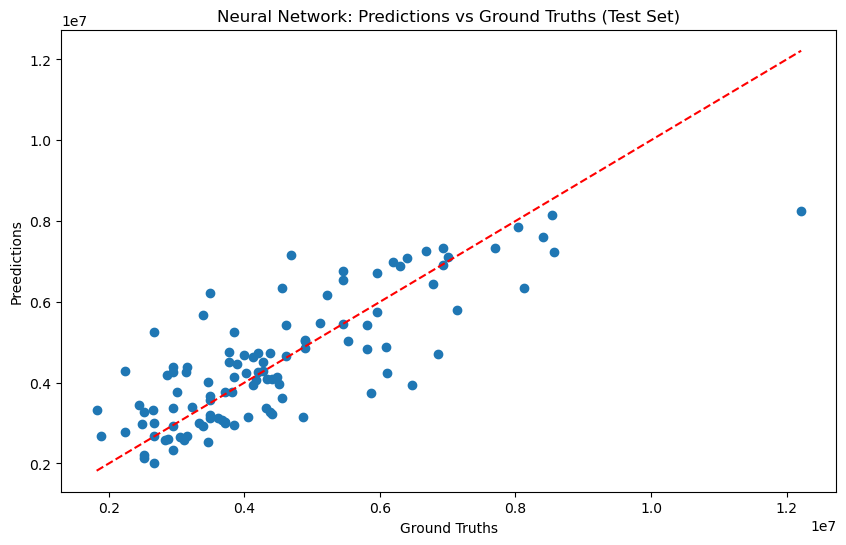

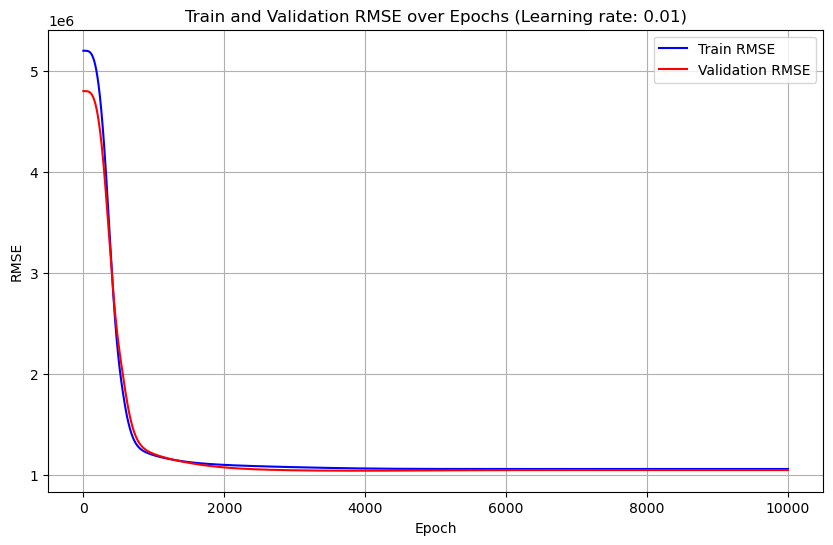

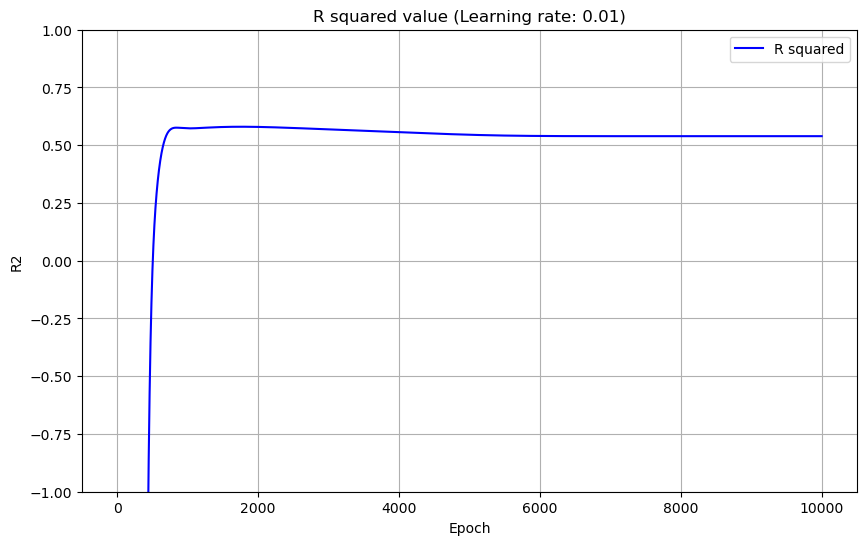

In [ ]:
number_of_epochs=10000
learning_rate=0.01
linear_model = nn.Sequential(
    nn.Linear(train_X.shape[1],64),
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32, 1)
)
optimizer = optim.Adam(linear_model.parameters(), lr=learning_rate)
start_time = time.time()
train_rmse, val_rmse, R2=train(
      n_epochs=number_of_epochs,
      model=linear_model,
      optimizer=optimizer,
      loss_fn=nn.MSELoss(),
      x_train=train_X,
      y_train=train_Y,
      x_val=val_X,
      y_val=val_Y
  )
end_time = time.time()
elapsed_time = end_time - start_time
formatted_time = str(timedelta(seconds=elapsed_time))
# Print the training time
print(f"Training time for learning rate {learning_rate}: {formatted_time}")
total_params, trainable_params = get_model_size(linear_model)
print(f"Model with learning rate {learning_rate}:")
print(f"  Total parameters: {total_params}")
print(f"  Trainable parameters: {trainable_params}")
#print(f"Final parameters with learning rate {learning_rate}: {trained_parameters}")
plt.figure(figsize=(10, 6))
plt.plot(range(0, number_of_epochs+1), train_rmse, label='Train RMSE', color='blue')
plt.plot(range(0, number_of_epochs+1), val_rmse, label='Validation RMSE', color='red')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title(f'Train and Validation RMSE over Epochs (Learning rate: {learning_rate})')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(0, number_of_epochs+1), R2, label='R squared', color='blue')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.title(f'R squared value (Learning rate: {learning_rate})')
plt.legend()
plt.grid(True)
plt.ylim(-1, 1)
plt.show()